In [1]:
!pip install google-play-scraper #scrapping reviews
!pip install emoji
!pip install Sastrawi
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00


In [2]:
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
!wget https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt -O stopword

--2023-09-05 18:02:37--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49923 (49K) [text/plain]
Saving to: ‘kamus_alay.csv’

kamus_alay.csv      100%[===================>]  48.75K  --.-KB/s    in 0.004s  

2023-09-05 18:02:37 (12.7 MB/s) - ‘kamus_alay.csv’ saved [49923/49923]

--2023-09-05 18:02:37--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict
import string

# NLP
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

import tensorflow as tf

from transformers import TFBertForSequenceClassification, BertConfig, BertTokenizer, TFAutoModelForSequenceClassification, TFAutoModel
from transformers import InputExample, InputFeatures
import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# from google_play_scraper import Sort, reviews_all, reviews

# result, continuation_token = reviews(
#     'com.telkom.tracencare',
#     lang='id', # defaults to 'en'
#     country='id', # defaults to 'us'
#     sort=Sort.MOST_RELEVANT, # defaults to Sort.NEWEST
#     count=50000, # defaults to 100
#     # filter_score_with=5 # defaults to None(means all score)
# )

# #result[:10]
# print(result[:10])
# print(len(result))

In [5]:
# # Download the file.
# import json

# resultjson = json.dumps(result, indent=4, sort_keys=True, default=str)
# with open('result.json', 'w') as f:
#   f.write(resultjson)

In [6]:
# reviews = {}
# for review in result:
#   if review['score'] not in reviews:
#     reviews[review['score']] = []
#   reviews[review['score']].append(review['content'])

# print(len(reviews[1]))

In [7]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
!ls /content/drive/MyDrive/Skripsi2023

app.json
prev5_result_to_csv.csv
result.json
result_to_csv.csv
SATUSEHAT_Reviews_Sentiment_Analysis_Ver_7_IndoBertweet.ipynb


In [9]:
import pandas as pd
import numpy as np

# df = pd.json_normalize(result)
# df.head()
df = pd.read_json("/content/drive/MyDrive/Skripsi2023/result.json")
df = df[:50000]
print(df.columns.values)

['at' 'content' 'repliedAt' 'replyContent' 'reviewCreatedVersion'
 'reviewId' 'score' 'thumbsUpCount' 'userImage' 'userName']


In [10]:
df['at'] = pd.to_datetime(df['at'])
print(df.dtypes)

at                      datetime64[ns]
content                         object
repliedAt                       object
replyContent                    object
reviewCreatedVersion            object
reviewId                        object
score                            int64
thumbsUpCount                    int64
userImage                       object
userName                        object
dtype: object


In [11]:
df['score'].value_counts()

1    31516
5     6069
2     5836
3     4315
4     2264
Name: score, dtype: int64

In [12]:
pd.set_option("display.max_rows", None)
df['reviewCreatedVersion'].value_counts()

3.4.6      6071
5.2.0      3849
5.0.0      3416
4.0.2      3165
3.4.5      2631
3.4.3      2068
3.4.1      1942
5.2.1      1936
3.2.6      1752
5.3.1      1332
3.4.0      1065
4.6.0      1045
5.3.2      1028
4.0.5       952
3.4.4       900
4.5.9.1     861
4.0.7       660
3.3.4       631
4.5.7       548
2.0.0       494
4.0.8       482
3.3.6       455
4.5.8       450
3.4.2       381
4.1.1       349
4.1.0       341
4.5.4       326
4.0.91      284
4.0.9       280
3.3.5       269
4.4.1       236
4.5.0       223
1.4.0       205
4.4.4       205
4.0.6       197
4.4.6       189
2.0.3       173
4.1.16      170
4.4.3       153
2.0.2       144
4.4.5       143
4.3.0       125
4.5.9       118
3.1.3       117
4.5.6       111
4.2.1       111
4.5.3        93
4.4.3.2      81
4.4          78
2.1.4        72
4.4.8        70
4.5.1        59
4.5.2        59
4.4.7        59
2.3.0        57
4.2.0        56
2.2.2        51
4.5.5        44
3.1.2        43
3.1.1        34
4.4.3.1      33
1.0.1        32
1.1.0   

In [13]:
df = df[["at", "reviewCreatedVersion", "content", "score"]]
df[:10]

,at,reviewCreatedVersion,content,score
0,2023-04-02 10:33:15,5.3.1,Semakin kesini aplikasi ini semakin menyulitka...,1
1,2023-04-01 02:22:55,5.3.1,"Aplikasi jeblok, gini hari masih bikin aplikas...",1
2,2023-03-31 02:00:53,5.3.1,Mohon dpt sgra diperbaiki krn pedulilindungi s...,1
3,2023-04-05 14:39:36,5.3.2,"Tidak bisa dibuka, logo doang di tengah layar....",5
4,2023-04-01 04:31:40,5.3.1,"Woi login jangan OTP via Whatsapp doang lah, k...",1
5,2023-04-07 01:27:22,5.3.2,Habis pembaharuan tidak bisa dibuka. Udh unins...,1
6,2023-04-03 01:05:39,5.3.1,"Setelah dipeebarui. Fitur download sertifikat,...",1
7,2023-04-05 03:27:42,5.3.2,"Aplikasinya tidak bisa terbuka, malah makin ri...",1
8,2023-04-02 05:25:43,5.3.1,Sudah benar2 peduli lindungi malah diganti. Se...,1
9,2023-03-12 11:53:17,5.2.1,"Tolong la Diperbaiki, banyak masyarakat yg tid...",1


In [14]:
def score_to_sentiment(x):
  if x > 0 and x <= 2:
    return "negative"
  elif x == 3:
    return "neutral"
  elif x >= 4 :
    return "positive"

df["sentiment"] = df["score"].apply(score_to_sentiment)

df[:10]

<ipython-input-14-9bccb2c2edbe>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["score"].apply(score_to_sentiment)


,at,reviewCreatedVersion,content,score,sentiment
0,2023-04-02 10:33:15,5.3.1,Semakin kesini aplikasi ini semakin menyulitka...,1,negative
1,2023-04-01 02:22:55,5.3.1,"Aplikasi jeblok, gini hari masih bikin aplikas...",1,negative
2,2023-03-31 02:00:53,5.3.1,Mohon dpt sgra diperbaiki krn pedulilindungi s...,1,negative
3,2023-04-05 14:39:36,5.3.2,"Tidak bisa dibuka, logo doang di tengah layar....",5,positive
4,2023-04-01 04:31:40,5.3.1,"Woi login jangan OTP via Whatsapp doang lah, k...",1,negative
5,2023-04-07 01:27:22,5.3.2,Habis pembaharuan tidak bisa dibuka. Udh unins...,1,negative
6,2023-04-03 01:05:39,5.3.1,"Setelah dipeebarui. Fitur download sertifikat,...",1,negative
7,2023-04-05 03:27:42,5.3.2,"Aplikasinya tidak bisa terbuka, malah makin ri...",1,negative
8,2023-04-02 05:25:43,5.3.1,Sudah benar2 peduli lindungi malah diganti. Se...,1,negative
9,2023-03-12 11:53:17,5.2.1,"Tolong la Diperbaiki, banyak masyarakat yg tid...",1,negative


In [15]:
# df[(df['score'] >= 3)][:10]
df[(df['sentiment'] == "positive")].shape[0]

8333

In [16]:
df1 = df[(df['sentiment'] == "negative")][:3000]
df2 = df[(df['sentiment'] == "neutral")][:3000]
df3 = df[(df['sentiment'] == "positive")][:3000]
df_labeled = [df1, df2, df3]
df = pd.concat(df_labeled)
df.shape[0]

9000

In [17]:
# df.to_csv("/content/drive/MyDrive/Skripsi2023/result_to_csv.csv")

In [18]:
df = pd.read_csv("/content/drive/MyDrive/Skripsi2023/result_to_csv.csv")
df['at'] = pd.to_datetime(df['at'])

negative    3000
neutral     3000
positive    3000
Name: sentiment, dtype: int64


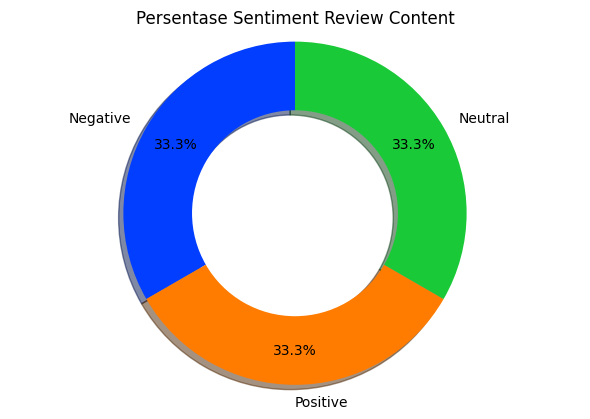

In [19]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()
# Plot arguments
sizes = df.sentiment.value_counts()
labels = ["Negative", "Positive", "Neutral"]
colors = sns.color_palette('bright')
explode = (0,0,0)

# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Persentase Sentiment Review Content')
print(sizes)

plt.show()

In [20]:
df.shape

(9000, 6)

In [21]:
df.content = df.content.apply(lambda x: x.lower())
df[:5]

,Unnamed: 0,at,reviewCreatedVersion,content,score,sentiment
0,0,2023-04-02 10:33:15,5.3.1,semakin kesini aplikasi ini semakin menyulitka...,1,negative
1,1,2023-04-01 02:22:55,5.3.1,"aplikasi jeblok, gini hari masih bikin aplikas...",1,negative
2,2,2023-03-31 02:00:53,5.3.1,mohon dpt sgra diperbaiki krn pedulilindungi s...,1,negative
3,4,2023-04-01 04:31:40,5.3.1,"woi login jangan otp via whatsapp doang lah, k...",1,negative
4,5,2023-04-07 01:27:22,5.3.2,habis pembaharuan tidak bisa dibuka. udh unins...,1,negative


In [22]:
count = 0
for x in df.itertuples():
  if count == 10:
    break
  print(x.content)
  count += 1

semakin kesini aplikasi ini semakin menyulitkan untuk dibuka, terutama selalu update dan tampilan nya tetap saja bug, hank, tidak bergerak, atau apapun istilahnya, menjadi tidak bermanfaat apalagi bagi orang2x yang sedang dalam keadaan urgent membutuhkan aplikasi ini tapi di sistem nya masih banyak kekuangan terutama lemot, dan tidak bisa terbuka di hp
aplikasi jeblok, gini hari masih bikin aplikasi yang gampang error. alasannya karena antusiasme tinggi?? masih banyak aplikasi lain yg antusiasmenya jauuuhhh lbh tinggi tapi ngga crash/error, ini login aja ngga bisa, apalagi kasusnya terus berulang ngga pernah selesai. dari awal kan bisa aja langsung siapin infrastruktur keperluan coding dan servernya untuk minimal bisa handle jumlah penduduk indonesia plus sedikit spare biar lbh pede lancar. biar ngga kaya gini alesannya, antusiasme tinggi.....
mohon dpt sgra diperbaiki krn pedulilindungi stelah updte jadi satu sehat saya mengalami bugs di apps ini, ketika msk apps layar hanya freeze di

In [23]:
def clean_data(x):
    x = x.lower()
    # Menghapus @username
    x = re.sub(r"@[A-Za-z0-9]\w+", "", x)  # Remove @
    # Menghapus link website
    x = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x)  # Remove http links
    # Menghapus new line
    x = re.sub(r"\n", " ", x)
    # Menghapus whitespace pada sekitar kalimat
    x = x.strip()
    # Menghapus hashtag
    x = re.sub(r"\B(#\w+)+", r" ", x)
    # Mengubah % menjadi persen
    x = re.sub(r"(\d+) ?%", "\1 persen", x)
    # Mengubah emoji menjadi kata
    x = emoji.demojize(x, delimiters=(" ", " "))
    # Menghapus simbol-simbol
    x = re.sub(r"[^\w]", " ", x)
    # Menghapus huruf berulang
    x = re.sub(r'(.)\1+', r'\1\1', x)
    # Menghapus spasi berulang
    x = re.sub('\s+', ' ', x)

    return x

In [24]:
kamus_alay = pd.read_csv('kamus_alay.csv')

alay_word_dict = {}
for ele in kamus_alay.itertuples():
  alay_word_dict[ele.slang] = ele.formal

# Custom kata alay
custom_word = {
    "apk": "aplikasi",
    "apknya": "aplikasi",
    "aplikasinya": "aplikasi",
    "ayoo": "ayo",
    "ayok": "ayo",
    "bgt": "sangat",
    "banget": "sangat",
    "bgs": "bagus",
    "cvd": "covid",
    "pirus": "virus",
    "jlk": "jelek",
    "kuy": "ayo",
    "knapa": "kenapa",
    "knapaa": "kenapa",
    "knp": "kenapa",
    "knpa": "kenapa",
    "knpaa": "kenapa",
    "nggak": "enggak",
    "enggak": "enggak",
    "tidak": "enggak",
    "smph": "sampah",
    "samsek": "sama sekali"
}

alay_word_dict.update(custom_word)

def normalize_text(x):
  # Normalize "kata alay" to "kata formal"
  x = [alay_word_dict[word] if word in alay_word_dict else word for word in x]
  return x

In [25]:
# Stopwords
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('indonesian'))

negation_words = ['tak', 'tidak', 'gak', 'enggak', 'nggak', 'jangan', 'bukan']
strong_words = ["sekali", 'sangat', 'terlalu', 'amat', 'benar', 'makin']
other_words = ["hari", "jauh", "siapa", "kenapa", "bagaimana", "dapat", "dapatkah", "apa", "kapan", "mengapa", ]
stopwords_to_remove = [negation_words, strong_words, other_words]

with open('./stopword') as f:
  custom_stopwords = f.read().splitlines()

for words_list in stopwords_to_remove:
  for word in words_list:
    stopwords_list.discard(word)

def remove_stopwords(x):
  x = [word for word in x if word not in stopwords_list]
  return x

print(len(stopwords_list))
print(len(custom_stopwords))

737
357


In [26]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stemmer.stem("aplikasinya mengecewakan")
def stemming_text(x):
  x = [stemmer.stem(word) for word in x]
  return x

In [27]:
def preprocess_data(df, stem=False):
  df_processed = df.copy()
  df_processed.content = df_processed.content.apply(clean_data)
  df_processed.content = df_processed.content.apply(word_tokenize)
  df_processed.content = df_processed.content.apply(normalize_text)
  df_processed.content = df_processed.content.apply(remove_stopwords)
  if stem:
    df_processed.content = df_processed.content.apply(stemming_text)
  df_processed.content = df_processed.content.apply(lambda x: ' '.join(x))
  df_processed.sentiment = df_processed.sentiment.map({
    "positive": 0,
    "neutral": 1,
    "negative": 2,
  })
  return df_processed

df_preprocessed = preprocess_data(df)
df_preprocessed[:10]

,Unnamed: 0,at,reviewCreatedVersion,content,score,sentiment
0,0,2023-04-02 10:33:15,5.3.1,kesini aplikasi menyulitkan dibuka update tamp...,1,2
1,1,2023-04-01 02:22:55,5.3.1,aplikasi jeblok hari bikin aplikasi gampang er...,1,2
2,2,2023-03-31 02:00:53,5.3.1,mohon dapat sgra diperbaiki pedulilindungi upd...,1,2
3,4,2023-04-01 04:31:40,5.3.1,woi login jangan otp via whatsapp doang kasih ...,1,2
4,5,2023-04-07 01:27:22,5.3.2,habis pembaharuan enggak dibuka uninstall berk...,1,2
5,6,2023-04-03 01:05:39,5.3.1,dipeebarui fitur download sertifikat klik pemb...,1,2
6,7,2023-04-05 03:27:42,5.3.2,aplikasi enggak terbuka makin ribet aplikasi l...,1,2
7,8,2023-04-02 05:25:43,5.3.1,benar-benar peduli lindungi diganti diganti sa...,1,2
8,9,2023-03-12 11:53:17,5.2.1,tolong diperbaiki masyarakat enggak memakai wh...,1,2
9,10,2023-04-06 04:18:21,5.3.2,enggak buka alesannya suruh update pas cek pla...,1,2


In [28]:
def make_corpus(column):

    text_body = ""


    for sentences in column:
      sentences = sentences.split(' ')
      text_body += ' ' +' '.join(sentences)

    print(text_body)
    # transform list of words into 1 body of text
    corpus = re.sub('[ ]+',' ', text_body) # replace double whitespace with one

    return corpus

In [29]:
corpus = make_corpus(df_preprocessed.content)

#Sub-Corpus Split by Sentiments
corpus_positive = make_corpus(df_preprocessed[(df_preprocessed['sentiment'] == 0)].content)
corpus_neutral = make_corpus(df_preprocessed[(df_preprocessed['sentiment'] == 1)].content)
corpus_negative = make_corpus(df_preprocessed[(df_preprocessed['sentiment'] == 2)].content)

 kesini aplikasi menyulitkan dibuka update tampilan nya bug hank enggak bergerak apapun istilahnya enggak bermanfaat orang2x urgent membutuhkan aplikasi sistem nya kekuangan lambat enggak terbuka hp aplikasi jeblok hari bikin aplikasi gampang error alasannya antusiasme aplikasi antusiasmenya jauuhh enggak crash error login enggak kasusnya berulang enggak selesai langsung siapin infrastruktur keperluan coding servernya minimal handle penduduk indonesia plus spare biar percaya diri lancar biar enggak kaya alesannya antusiasme mohon dapat sgra diperbaiki pedulilindungi updte sehat mengalami bugs apps masuk apps layar freeze tampilan bertuliskan sehat tipe hp samsung flip 3 uninstall berulang2 kali enggak masuk apps coba hp tmn data hp tidak masuk tidak support bandara butuh apps bagaimana solusinya mhn sgera ditanggapi woi login jangan otp via whatsapp doang kasih pilihan via sms login pakai email dibilang terdaftar daftar bilang exist bagaimana update user interface berubah proyek akal a

In [30]:
# counting unique words
corpus_set = set(corpus.split(' '))
corpus_positive_set = set(corpus_positive.split(' '))
corpus_neutral_set = set(corpus_neutral.split(' '))
corpus_negative_set = set(corpus_negative.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')
print(f'Count of unique words in corpus positive: {len(corpus_positive_set)}')
print(f'Count of unique words in corpus neutral: {len(corpus_neutral_set)}')
print(f'Count of unique words in corpus negative: {len(corpus_negative_set)}')

Count of unique words in corpus: 10119
Count of unique words in corpus positive: 5681
Count of unique words in corpus neutral: 5237
Count of unique words in corpus negative: 4547


In [31]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [32]:
corpus_freq = word_freq(corpus, top=20)
corpus_positive_freq = word_freq(corpus_positive, top=20)
corpus_neutral_freq = word_freq(corpus_neutral, top=20)
corpus_negative_freq = word_freq(corpus_negative, top=20)

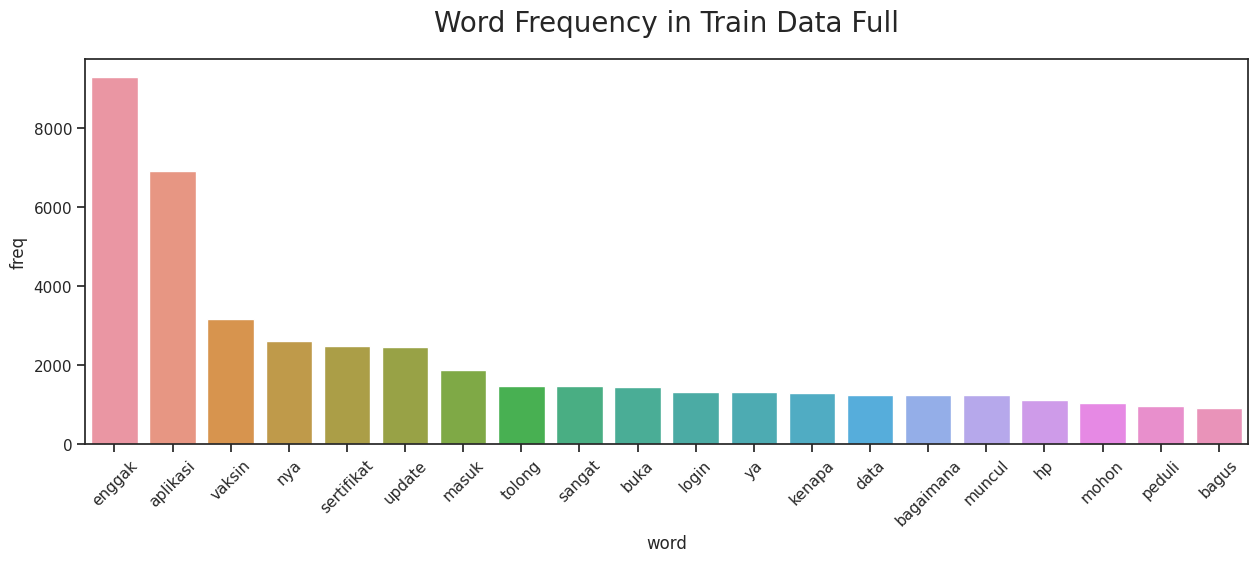

In [33]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))
sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data Full')
ax1.tick_params(axis='x', rotation=45)

plt.show()

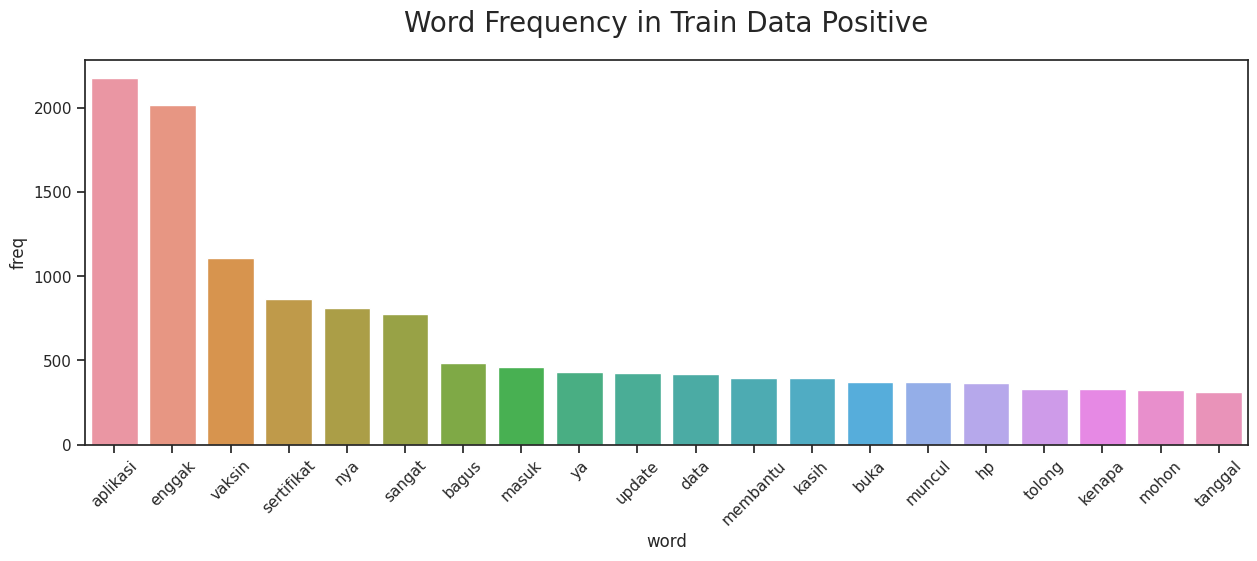

In [34]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))
sns.barplot(x='word', y='freq', data=corpus_positive_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data Positive')
ax1.tick_params(axis='x', rotation=45)

plt.show()

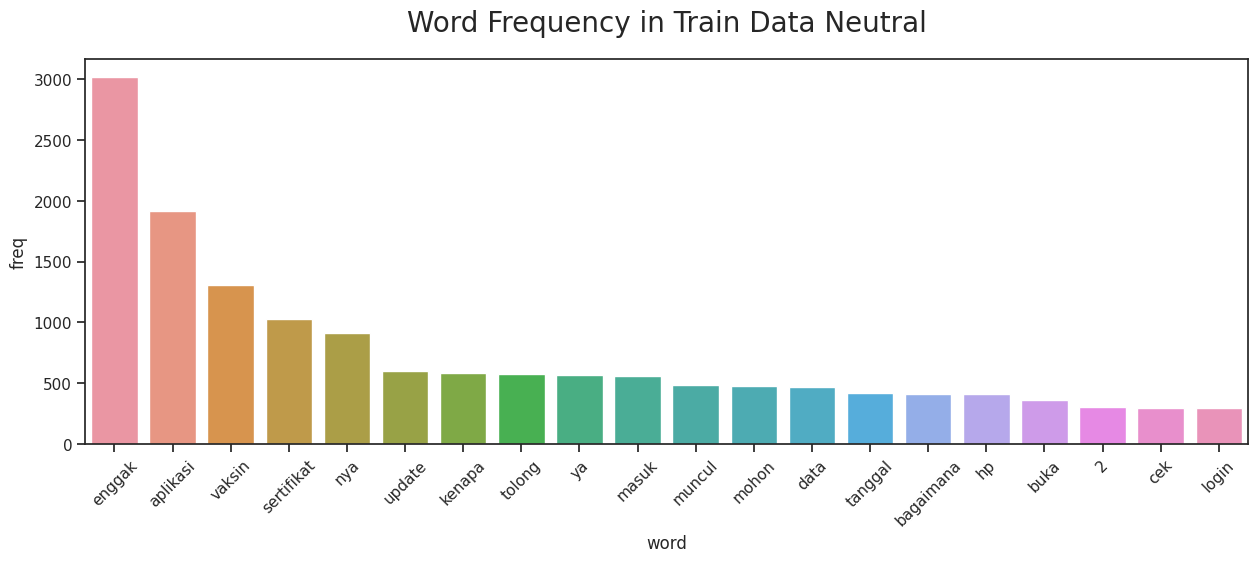

In [35]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))
sns.barplot(x='word', y='freq', data=corpus_neutral_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data Neutral')
ax1.tick_params(axis='x', rotation=45)

plt.show()

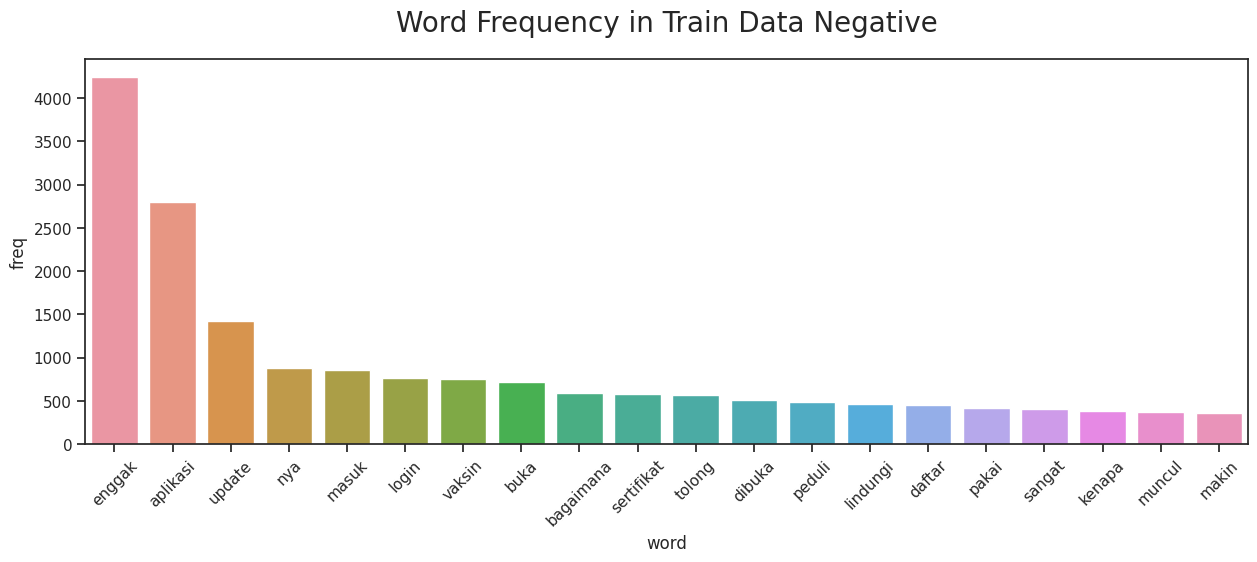

In [36]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))
sns.barplot(x='word', y='freq', data=corpus_negative_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data Negative')
ax1.tick_params(axis='x', rotation=45)

plt.show()

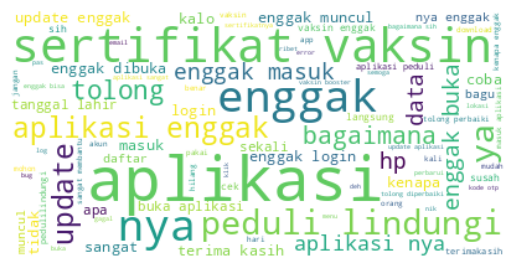

In [37]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

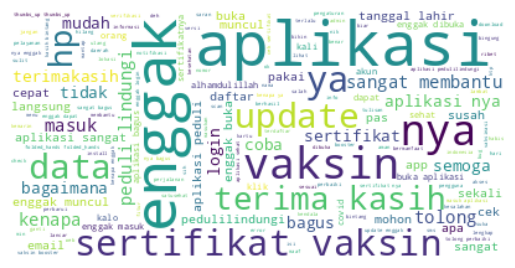

In [38]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus_positive)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

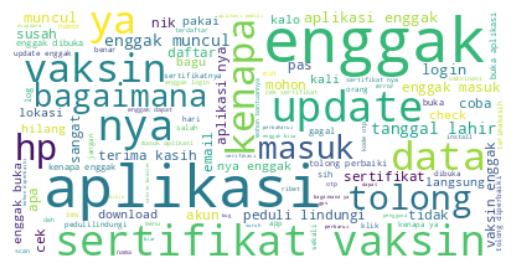

In [39]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus_neutral)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

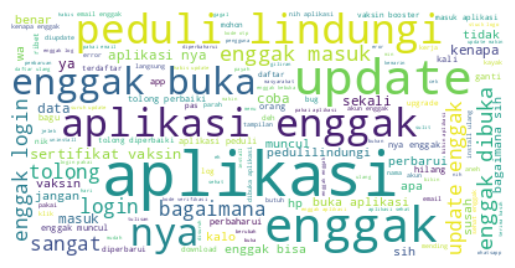

In [40]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus_negative)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [41]:
# train val split
train_set, val_set = train_test_split(df_preprocessed, test_size=0.2, stratify=df_preprocessed.sentiment)
val_set, test_set = train_test_split(val_set, test_size=0.5, shuffle=False)

In [42]:
def convert_data_to_examples(input_set,  DATA_COLUMN, LABEL_COLUMN):
  set_InputExamples = input_set.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  return set_InputExamples

In [43]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


In [44]:
def convert_data_to_tf_dataset(train, val, data_column, label_column, tokenizer):
  train_InputExamples = convert_data_to_examples(train, data_column, label_column)
  validation_InputExamples = convert_data_to_examples(val, data_column, label_column)

  train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
  train_data = train_data.shuffle(100).batch(32).repeat(2)

  validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
  validation_data = validation_data.batch(32)
  return train_data, validation_data

In [45]:
def bert_model(pretrained_model, from_pt=False):
  tokenizer = BertTokenizer.from_pretrained(pretrained_model)
  config = BertConfig.from_pretrained(pretrained_model)
  config.labels = 3

  base_model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=3, from_pt=from_pt)
  return base_model, tokenizer
model, tokenizer = bert_model('indolem/indobertweet-base-uncased', from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
DATA_COLUMN = 'content'
LABEL_COLUMN = 'sentiment'

train_data, validation_data = convert_data_to_tf_dataset(train_set, val_set, DATA_COLUMN, LABEL_COLUMN, tokenizer)

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_data, epochs=7, validation_data=validation_data, batch_size=32)

Epoch 1/7
450/450 [==============================] - 431s 819ms/step - loss: 1.1640 - accuracy: 0.3365 - val_loss: 1.1300 - val_accuracy: 0.3300
Epoch 2/7
450/450 [==============================] - 355s 790ms/step - loss: 1.1260 - accuracy: 0.3403 - val_loss: 1.1289 - val_accuracy: 0.3300
Epoch 3/7
450/450 [==============================] - 354s 787ms/step - loss: 1.1353 - accuracy: 0.3376 - val_loss: 1.1918 - val_accuracy: 0.3300
Epoch 4/7
450/450 [==============================] - 353s 785ms/step - loss: 1.1450 - accuracy: 0.3444 - val_loss: 1.1357 - val_accuracy: 0.3300
Epoch 5/7
450/450 [==============================] - 354s 786ms/step - loss: 1.1417 - accuracy: 0.3346 - val_loss: 1.1238 - val_accuracy: 0.3300
Epoch 6/7
450/450 [==============================] - 352s 782ms/step - loss: 1.1387 - accuracy: 0.3293 - val_loss: 1.1728 - val_accuracy: 0.3300
Epoch 7/7
450/450 [==============================] - 353s 785ms/step - loss: 1.1266 - accuracy: 0.3378 - val_loss: 1.1587 - val_ac

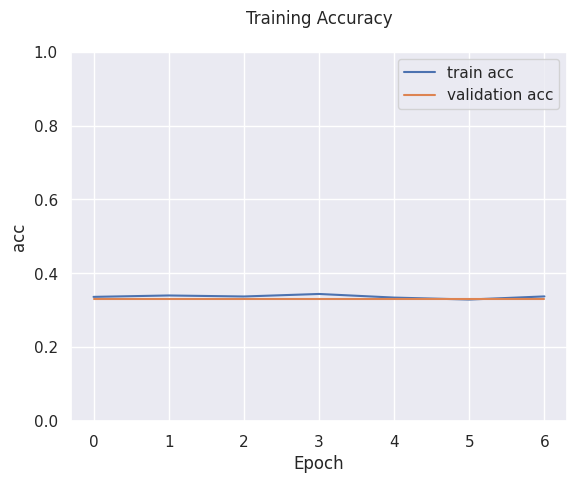

In [48]:
sns.set()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Training Accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

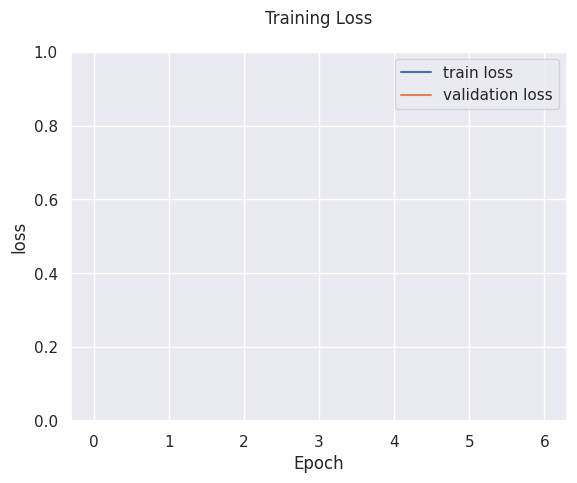

In [49]:
sns.set()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [50]:
test_sentences = list(test_set["content"])
tf_batch = tokenizer(test_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch) #ResourceExhaustedError: Exception encountered when calling layer "Embedding"/"LayerNorm"
#Google said too big data, tried reducing batch and epochs still no dice.
#Try reducing review number from 50k next time.

tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels =  ["Positive", "Neutral", "Negative"]
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
test_pred = []
for i in range(len(test_sentences)):
  test_pred.append(label[i])
print(test_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

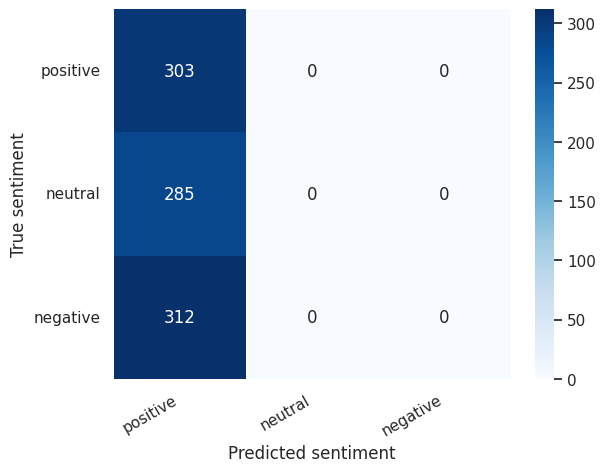

In [51]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_set.sentiment, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [52]:
print(classification_report(test_set.sentiment, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.34      1.00      0.50       303
     neutral       0.00      0.00      0.00       285
    negative       0.00      0.00      0.00       312

    accuracy                           0.34       900
   macro avg       0.11      0.33      0.17       900
weighted avg       0.11      0.34      0.17       900



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
